# Visualizing a representation of the `penguins` dataset in 2D with *Self-Organizing Map*

In [01_kmeans_clustering.ipynb](./01_kmeans_clustering.ipynb) we use/used the `K-Means` algorithm to find groups of data points. Here, we want to learn a representation of the dataset. K-Means may also be used for representation learning in a sense that it discretizes the data space into disjoint regions. However, once we have a dataset that has more than three dimensions, visualizing these groups becomes challenging.

On the other hand, a *Self-Organizing Map* is similar to `K-Means` in a sense that it also operates with centroids to which data samples get mapped, yet one very important difference here is that the centroids are chained together from the very beginning so after it discovers and maps the dataset, the neighboring information can be used to flatten the SOM grid into a 2D visual. As hinted, SOM itself could be used for clustering as well, yet in this notebook the objective is to learn and visualize the simpler representation of the original dataset.

In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

RAND = 42

## Dataset

In [16]:
X_scaled = pd.read_csv("../datasets/penguins/simple/X_scaled.csv", index_col=0, header=0)
y = pd.read_csv("../datasets/penguins/simple/y.csv", index_col=0, header=0)

## Experiment 1: Use only two features

In this experiment, we treat the first two features of the dataset as it was a dataset with arbitrary dimensions and use SOM to learn the representation of it and to visualize it in 2D. In this case we will be able to verify the converge easily.

1. Define hyperparameters

	> use `calc_recommended_grid_size` methods to get candidate values for `d1` and `d2`

	> e.g.: `print("Recommended total node count and dimension size for SOM:", calc_recommended_grid_size(...))`

2. Fit SOM

	> use `train_som` method to obtain an `som` object fitted on the data

	> observe the quality of the SOM outputted, and experiment with different hyperparameter combinations to arrive at a better representation

	> *Quantization error (QE)* measures the Mean Residual from best-matching nodes aka. nearest centroid

	> *Topographic error (TE)* measures the proportion of data points for which the 1st and 2nd best-matching units are not neighbors in the SOM grid

3. Extract learned node weights (prototype / representative point positions) from SOM

	> use `som.get_weights()` and flatten them

4. Visualize these 2D coordinates on the 2D dataset

	We may expect to end up with a similar results but could be better:

	![](./_images/som_representation_expectation.png)

5. Visualize the representation via the SOM maps

	We may expect to end up with a similar results but could be better:

	![](./_images/som_representation_maps_expectation.png)

In [17]:
from _utilities.som import calc_recommended_grid_size, train_som
from _utilities.som_plot import visualize_distance_map, visualize_hitmap, place_node_edges

### 1. Define Hyperparameters & Grid Shape
First, we calculate the optimal grid dimensions based on the shape of the input data (`X_scaled`). We will use these calculated dimensions (`d1` and `d2`) to configure the SOM in the next step.

In [18]:
# Calculate recommended grid size based on data shape (usually 5 * sqrt(N))
grid_size = calc_recommended_grid_size(X_scaled)
print("Recommended total node count and dimension size for SOM:", grid_size)

Recommended total node count and dimension size for SOM: (np.float64(92.46621004453465), 10)


In [19]:
selected_columns = X_scaled.columns[:2]
print("Selected features:", selected_columns.tolist())

X_scaled_F12 = X_scaled[selected_columns].copy().values
print("Data shape:", X_scaled_F12.shape)

Selected features: ['bill_length_mm', 'bill_depth_mm']
Data shape: (342, 2)


### Model Convergence & Topology Analysis

**1. Configuration Strategy**
To ensure the map unfolds smoothly, we initialized the training with robust hyperparameters:
* **Sigma ($\sigma \approx 12.3$):** Calculated as $\frac{\text{max\_dimension}}{3}$. This large initial neighborhood radius forces the nodes to move cohesively, preventing the map from twisting.
* **Iterations (5000):** This provided sufficient training steps for the map to transition from global ordering to fine-tuning.

**2. Visual Interpretation**
The visualization shows the SOM nodes (red) successfully learning the structure of the Penguin data (blue).
* Due to the **$37 \times 4$ grid shape**, the map behaves like a "principal curve" or a thick snake, winding through the center of the data density.
* The lattice is **untangled** and uniform, indicating successful self-organization.

**3. Quantitative Metric**
* **Topographic Error:** `0.003` (Near Zero).
* This confirms that the map is mathematically smooth and has effectively preserved the neighborhood relationships of the original high-dimensional data.

In [20]:
# Hyperparameters
d1_val = 4
d2_val = 37

# Calculate robust initial sigma (approx 12.33 for a length of 37)
initial_sigma = max(d1_val, d2_val) / 3

hyparams = {
    "d1": int(d1_val),
    "d2": int(d2_val),
    "sigma": initial_sigma, # start with D/2 for more robust map, or D/3 or smaller for more flexible 
    "learning_rate": .5, # start with .5, usually between .5-1
    "num_iteration": 100, # a single iteration touches every data point in the dataset
    "topology": "rectangular"
}

# Fit SOM
som = train_som(X=X_scaled_F12, **hyparams, random_seed=RAND, verb=True)

# Extract learned node weights
node_weights = som.get_weights()
node_weights_flat = node_weights.reshape(-1, node_weights.shape[2])

 [ 34200 / 34200 ] 100% - 0:00:00 left 
 quantization error: 0.3982676057537513

Brief quality of SOM:
Quantization error:	0.398
Topographic error:	0.003
Topographic error (VN):	0.003


### Understanding the Features: Bill Length vs. Depth

The visualization below plots the data based on two key physical measurements:

* **Bill Length (`bill_length_mm`):** Also known as **culmen length**, this measures the upper ridge of the beak from the base of the skull to the tip.
* **Bill Depth (`bill_depth_mm`):** This measures the vertical thickness of the beak.


**Why these features?**
Different penguin species have evolved distinct beak shapes to suit their diets. For example, **Gentoo** penguins typically have longer, thinner bills, while **Adélie** penguins have shorter, deeper bills. The SOM uses these physical differences to learn the structure of the data and cluster similar penguins together.

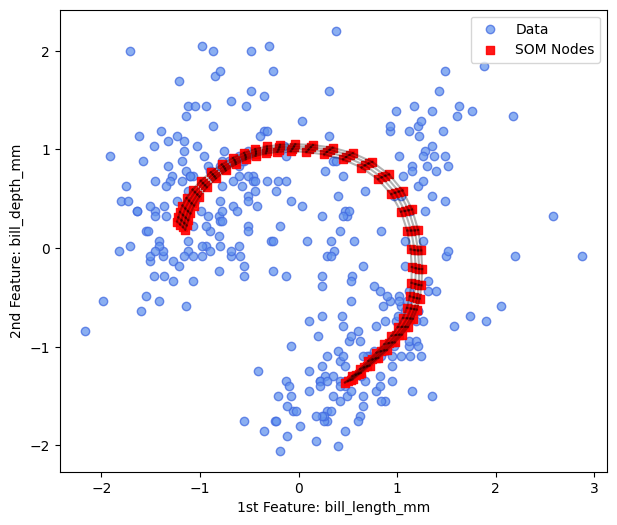

In [ ]:
# TODO: Visualize

plt.figure(figsize=(8, 6))

# data points
plt.scatter(X_scaled_F12[:, 0], X_scaled_F12[:, 1], color="cornflowerblue", edgecolors="royalblue", alpha=.75, label="Data")

# node positions
plt.scatter(node_weights_flat[:, 0], node_weights_flat[:, 1], color="red", edgecolors="red", marker="s", alpha=.9, label="SOM Nodes")
place_node_edges(som, ax=plt.gca())

plt.title("SOM Grid Adaptation (2 Features)")
plt.gca().set_aspect("equal")
plt.xlabel("1st Feature: " + selected_columns[0])
plt.ylabel("2nd Feature: " + selected_columns[1])
plt.legend()
plt.show()

### 5. Visualize SOM Maps
We can also analyze the quality of the learned representation using standard SOM visualizations:

* **Distance Map (U-Matrix):** Visualizes the Euclidean distance between neighboring nodes.
    * *Light areas* indicate clusters (nodes are similar).
    * *Dark/Red lines* indicate boundaries (nodes are different).
* **Hitmap:** Shows the "density" of the map by counting how many data samples matched each node.

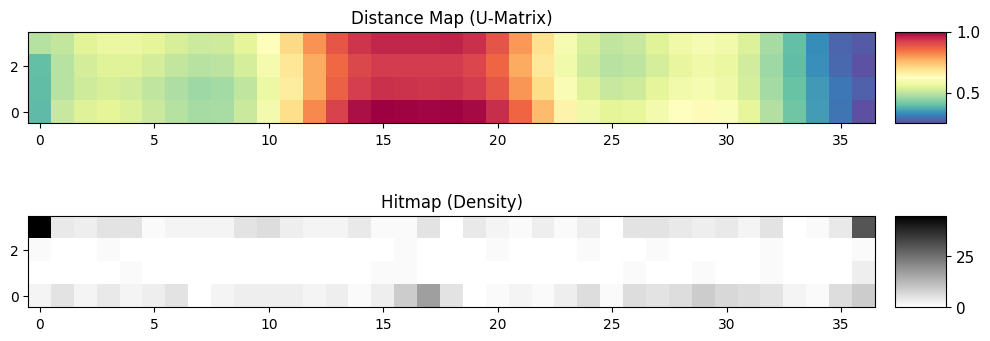

In [22]:
fig, (ax0, ax1) = plt.subplots(2, 1, figsize=(10, 4))

# 1. Distance Map
visualize_distance_map(som=som, X=X_scaled_F12, ax=ax0)
ax0.set_title("Distance Map (U-Matrix)")
ax0.set_aspect('equal') # <--- Forces the cells to be square, not stretched

# 2. Hitmap
visualize_hitmap(som=som, X=X_scaled_F12, ax=ax1)
ax1.set_title("Hitmap (Density)")
ax1.set_aspect('equal') 

plt.tight_layout()
plt.show()

In [23]:
del som, node_weights, node_weights_flat, hyparams, initial_sigma, d1_val, d2_val, grid_size

## Experiment 2: Use all the 4 features

Follow the same steps yet use the original dataset (`X_scaled`) not the limited one. The node positions can't be visualized in two or three dimensional plots. Either we plot the features pairwise, 3D, or use PCA to reduce dimensions. But we expect that the final SOM maps can capture the original high-dimensional structure and place similar items in the original space onto nearby locations in the SOM map. Compare the final results of the two scenarios.

### Project Context: Tuning SOM Grid Size
**1. The Goal:** Train a Self-Organizing Map (SOM) to visualize the 4D Penguin dataset in 2D.

**2. The Potential Problem ("The Giant Empty Net"):**
* We only have **344 penguins**. A too large grid can lead to a sparse map (too many "empty rooms") where the model struggled to cluster data effectively.

**3. The Solution:**
Use a forced square grid to maximize readability and create a clear 2D map, while keeping the node count close to the target ($\approx 5 \times \sqrt{N}$).
* **New Grid:** $12 \times 12$ (**144 nodes**).
* **Result:** A density of ~2-3 samples per node, resulting in a much richer feature map that is easier to visualize than a thin strip.

Forced Square grid: (12, 12) (Total nodes: 144)
Training 4D SOM...
 [ 34200 / 34200 ] 100% - 0:00:00 left 
 quantization error: 0.4533975116168289

Brief quality of SOM:
Quantization error:	0.453
Topographic error:	0.012
Topographic error (VN):	0.082


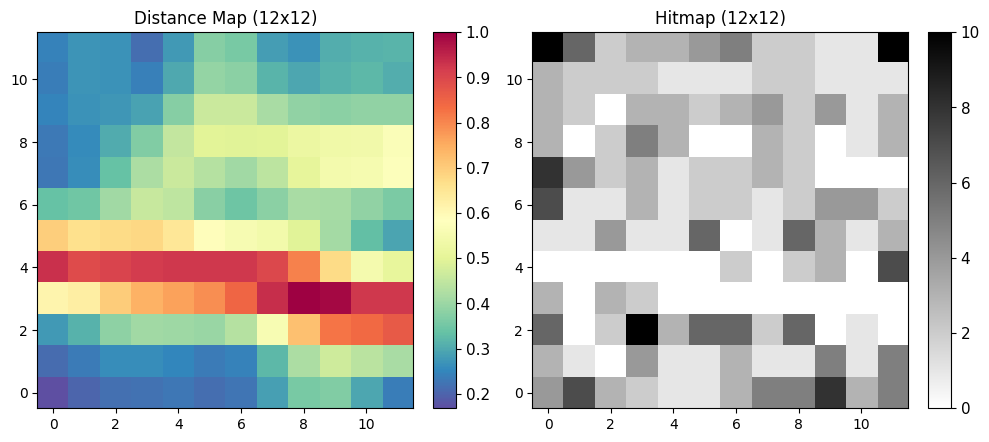

In [24]:
# Follow the same steps but for the original dataset

# 1. Forced Square Logic
# We want roughly 150 nodes, but arranged in a square (1:1 ratio)
target_nodes = 150

# Calculate the side length (square root of target)
side_length = int(target_nodes ** 0.5)

# Force both dimensions to be equal
d1_new = side_length
d2_new = side_length

print(f"Forced Square grid: ({d1_new}, {d2_new}) (Total nodes: {d1_new * d2_new})")

# 2. Define Hyperparameters with the new scaled dimensions
hyperparams_full = {
    "d1": d1_new,
    "d2": d2_new,
    "sigma": max(d1_new, d2_new) / 3,
    "learning_rate": 0.5,
    "num_iteration": 100, 
    "topology": "rectangular"
}

# 3. Train
print("Training 4D SOM...")
som_full = train_som(X=X_scaled.values, **hyperparams_full, random_seed=RAND, verb=True)

# 4. Extract learned node weights
node_weights = som_full.get_weights()
node_weights_flat = node_weights.reshape(-1, node_weights.shape[2])

# 5. Visualize
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(10, 5))

visualize_distance_map(som=som_full, X=X_scaled.values, ax=ax0)
ax0.set_title(f"Distance Map ({d1_new}x{d2_new})")

visualize_hitmap(som=som_full, X=X_scaled.values, ax=ax1)
ax1.set_title(f"Hitmap ({d1_new}x{d2_new})")

plt.tight_layout()
plt.show()

Although we cannot visualize the converge as simply as we did in the two-dimensional case, PCA can be used to do so. Since the dataset has only 4 dimensions, PCA is effective in this regard. Although, as one can observe, it only provides a pairwise view and not a unified one as the U-matrix does.

PCA explained variance: 0.973


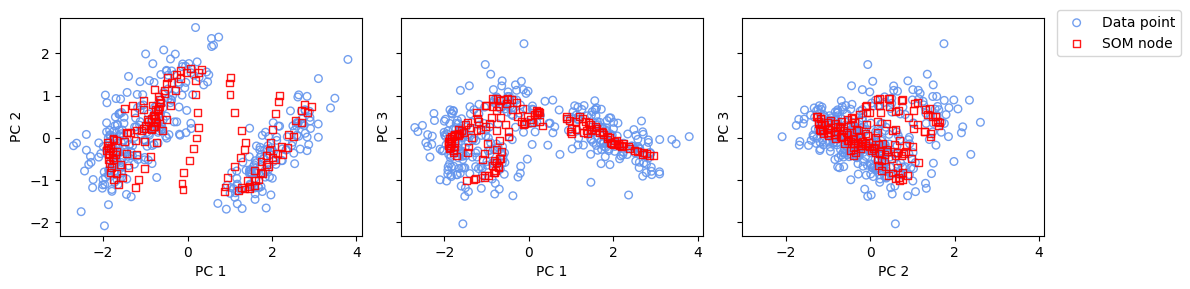

In [ ]:
from _utilities.som_plot import plot_three_variables_pairwise
from sklearn.decomposition import PCA

pca = PCA(n_components=3)
pca.fit(X_scaled.values)
X_scaled_pca = pca.transform(X_scaled.values)
node_weights_flat_pca = pca.transform(node_weights_flat)

explained_var = np.round(pca.explained_variance_ratio_.sum(), 3)
print("PCA explained variance:", explained_var)

title = f"SOM convergence in the Principal Component space explaining {explained_var*100}% variance"
plot_three_variables_pairwise(layers=[
		{
			"data": X_scaled_pca,
			"label": "Data point",
		},
		{
			"data": node_weights_flat_pca,
			"label": "SOM node",
			"styles": {"edgecolor": "red", "marker": "s", "s": 25}
		}
	], axis_label="PC", figsize=(12, 3), title=title)


In [26]:
from _utilities.som_plot import plot_in_3PC

plot_in_3PC(layers=[{
	"data": X_scaled_pca,
	"label": "Data point",
	"nodeWeights": node_weights_flat_pca,
	"gridShape": node_weights.shape,
	"marker": dict(size=4, opacity=.9, color="cornflowerblue")
	}])